# Evaluate Qwen Models on MMLU Dataset

Inference responses stored as CSV for each model

In [91]:
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce
import altair as alt
import numpy as np

In [3]:
mmlu = pd.read_csv("../training/mmlu_test_metadata.csv", usecols=['subject','answer','Qwen', 'MathQwen', 'CodeQwen','Qwen_correct', 'MathQwen_correct', 'CodeQwen_correct'])
mmlu.head()

,subject,answer,Qwen,MathQwen,CodeQwen,Qwen_correct,MathQwen_correct,CodeQwen_correct
0,abstract_algebra,2,6,2,6,0,1,0
1,abstract_algebra,3,8,1,8,0,0,0
2,abstract_algebra,4,0,0,0,0,0,0
3,abstract_algebra,2,D,2,0,0,1,0
4,abstract_algebra,2,2,0,6,1,0,0


## Overall Accuracy on All MMLU Subjects

In [4]:
total_examples = mmlu.shape[0]
qwen_correct = mmlu['Qwen_correct'].sum()
mathqwen_correct = mmlu['MathQwen_correct'].sum()
codeqwen_correct = mmlu['CodeQwen_correct'].sum()

qwen_accuracy = qwen_correct/total_examples
mathqwen_accuracy = mathqwen_correct/total_examples
codeqwen_accuracy = codeqwen_correct/total_examples
print(f'Qwen Accuracy: {qwen_accuracy:.3f}')
print(f'MathQwen Accuracy: {mathqwen_accuracy:.3f}')
print(f'CodeQwen Accuracy: {codeqwen_accuracy:.3f}')

Qwen Accuracy: 0.411
MathQwen Accuracy: 0.276
CodeQwen Accuracy: 0.350


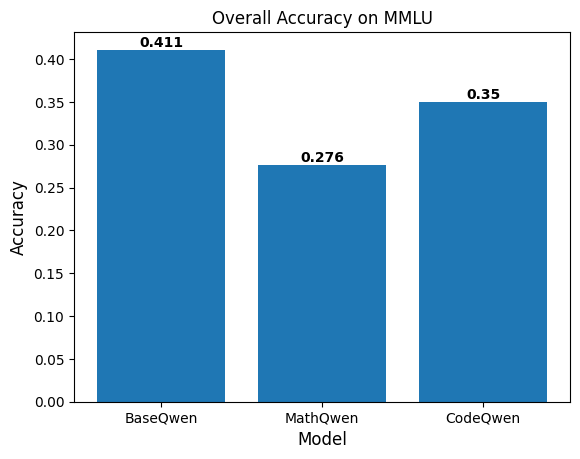

In [67]:
x_labels = ['BaseQwen', 'MathQwen', 'CodeQwen']
y_values = [qwen_accuracy, mathqwen_accuracy, codeqwen_accuracy]
bars = plt.bar(x_labels, y_values, color='tab:blue')
plt.xlabel('Model', size=12)
plt.ylabel('Accuracy', size=12)
plt.title('Overall Accuracy on MMLU')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval,
             round(yval,3), ha='center', va='bottom', fontweight='bold')

plt.savefig('baseline_overall_accuracy.png', format='png', dpi=200)
plt.show()

## Accuracy Based on Subject

In [68]:
qwen_correct_subject = mmlu.groupby('subject')['Qwen_correct'].mean()
mathqwen_correct_subject = mmlu.groupby('subject')['MathQwen_correct'].mean()
codeqwen_correct_subject = mmlu.groupby('subject')['CodeQwen_correct'].mean()

qwen_correct_subject.reset_index()
qwen_correct_subject.columns = ['subject', 'Qwen_Accuracy']
mathqwen_correct_subject.reset_index()
mathqwen_correct_subject.columns = ['subject', 'MathQwen_Accuracy']
codeqwen_correct_subject.reset_index()
codeqwen_correct_subject.columns = ['subject', 'CodeQwen_Accuracy']

dfs = [qwen_correct_subject, mathqwen_correct_subject, codeqwen_correct_subject]
merged_subjects = reduce(lambda left, right: pd.merge(left, right, on='subject'), dfs)
merged_subjects = merged_subjects.reset_index()
merged_subjects = merged_subjects.rename(columns={'subject': 'Subject', 'Qwen_correct': 'BaseQwen', 'MathQwen_correct': 'MathQwen','CodeQwen_correct': 'CodeQwen'})
merged_subjects.head()

,Subject,BaseQwen,MathQwen,CodeQwen
0,abstract_algebra,0.110000,0.190000,0.280000
1,anatomy,0.414815,0.244444,0.288889
2,astronomy,0.401316,0.289474,0.361842
3,business_ethics,0.540000,0.410000,0.440000
4,clinical_knowledge,0.418868,0.264151,0.350943


In [ ]:
melted_subjects = merged_subjects.melt(id_vars=['Subject'], var_name='Model', value_name='Accuracy')

chart = alt.Chart(melted_subjects).mark_line(point=True).encode(
    x = alt.X('Subject:N', axis=alt.Axis(labelAngle=-45)),
    y = 'Accuracy:Q',
    color = alt.Color('Model:N', scale=alt.Scale(scheme='set1')),
    tooltip=['Model', 'Subject', 'Accuracy']
).properties(
    title='Model Accuracy by Subject',
).configure_axis(
    labelFontSize=12,
    titleFontSize=16
).configure_title(
    fontSize=18
).configure_legend(
    titleFontSize=14,
    labelFontSize=12
)

chart.save('model_accuracy_by_subject_appendix.png', ppi=200)
chart

In [133]:
agg_df = melted_subjects.groupby('Model').agg(
    mean_accuracy=('Accuracy', 'mean'),
    min_accuracy=('Accuracy', 'min'),
    max_accuracy=('Accuracy', 'max')
).reset_index()

error_bar = alt.Chart(agg_df).mark_rule().encode(
    y=alt.Y('Model:N'),
    x='min_accuracy:Q',
    x2='max_accuracy'
)

mean_point = alt.Chart(agg_df).mark_point(filled=True, color='steelblue', size=80).encode(
    x=alt.Y('mean_accuracy:Q', title='Average Accuracy'),
    y=alt.X('Model:N', title='Model'),
    tooltip=('mean_accuracy')
)

dot_plot = error_bar + mean_point
dot_plot = dot_plot.properties(
    title='Model Accuracy by Subject',
).configure_axis(
    labelFontSize=14,
    titleFontSize=14
).configure_title(
    fontSize=14
)

dot_plot.save('model_accuracy_by_subject.png', ppi=200)
dot_plot

alt.LayerChart(...)

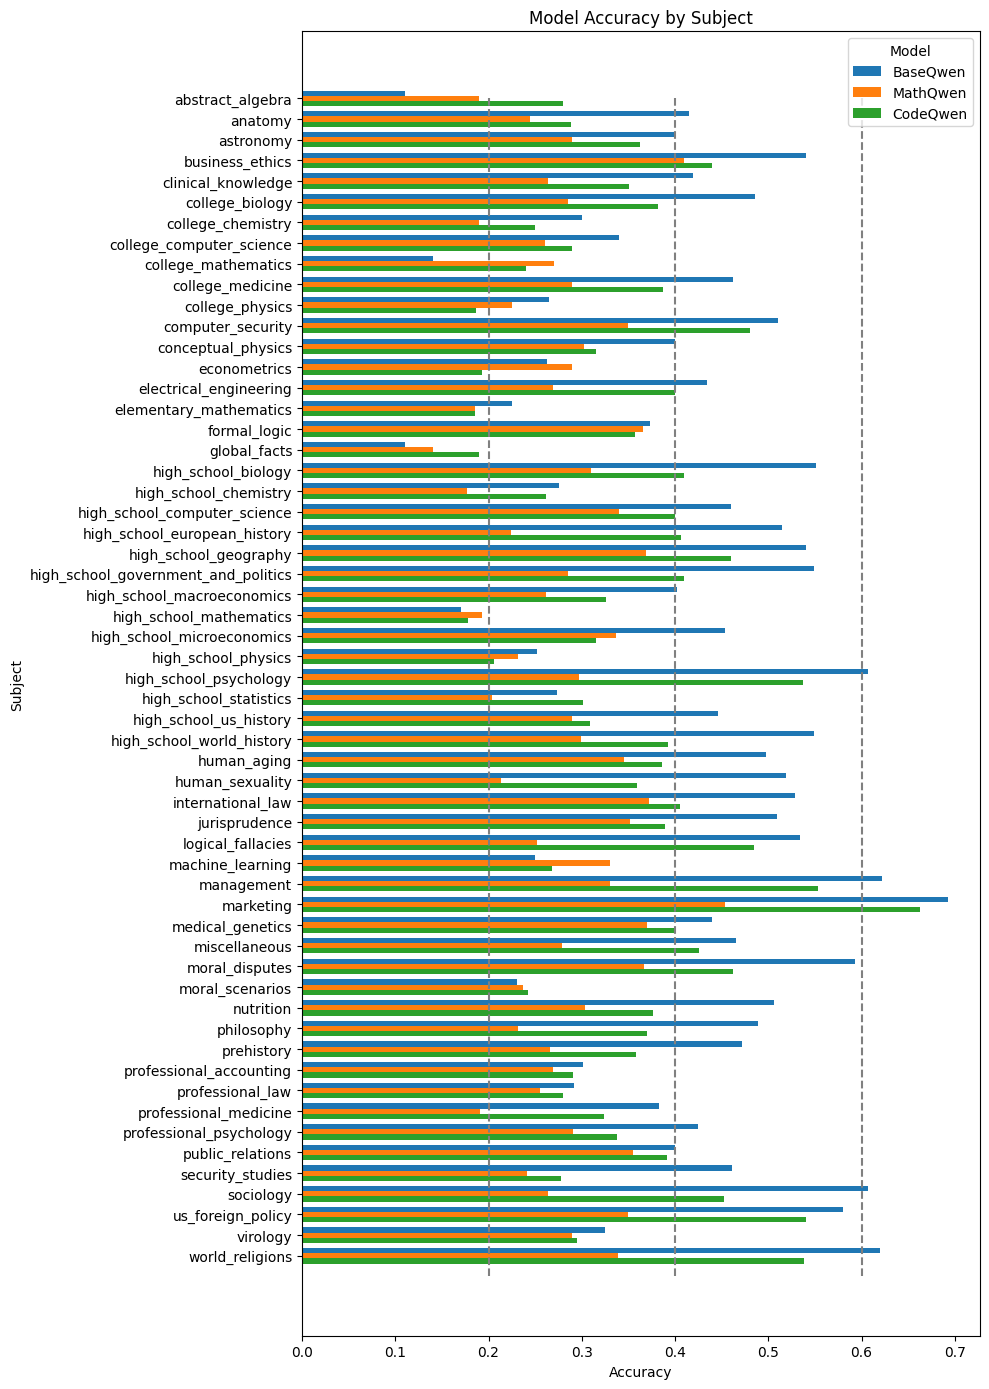

In [142]:
accuracies = {
    'BaseQwen': merged_subjects['BaseQwen'].tolist(),
    'MathQwen': merged_subjects['MathQwen'].tolist(),
    'CodeQwen': merged_subjects['CodeQwen'].tolist()
}
subjects = melted_subjects['Subject'].unique()

n_subjects = len(subjects) 
n_models = 3
bar_height = 0.25
group_height = bar_height * n_models
y_positions = np.arange(n_subjects)

fig, ax = plt.subplots(figsize=(10,14))
for i, model in enumerate(x_labels):
    offset = (i-1) * bar_height
    ax.barh(
        y_positions + offset,
        accuracies[model],
        height=bar_height,
        label=model, 
    )

ax.set_yticks(y_positions)
ax.set_yticklabels(subjects)
ax.invert_yaxis()
ax.set_xlabel('Accuracy')
ax.set_ylabel('Subject')
ax.set_title('Model Accuracy by Subject')
ax.legend(title='Model')
ax.vlines([0.2, 0.4, 0.6], ymin=0, ymax=n_subjects, colors='gray', linestyles='dashed')
plt.tight_layout()
plt.savefig('model_accuracy_by_subject2.png', format='png', dpi=400)
plt.show()